In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn


In [2]:
# Approximations to Maximal Eigenvalue of a matrix
Z = torch.randn(500, 500)
def Approximation(A):
    n = A.shape[0]
    sigma = torch.mm(A, A.t())
    eig = torch.symeig(sigma, eigenvectors = False)
    q = 5
    t = 5
    res = []
    for j in range(q):
        x = torch.randint(low = -1, high = 1, size = (n, ))
        x[x == 0] = 1
        x = x.type(torch.FloatTensor)
        for i in range(t):
            x = torch.matmul(sigma, x)
        lam = torch.matmul(torch.matmul(x.t(), sigma), x) / torch.matmul(x.t(), x)
        res.append(lam)

    res.sort()
    expected = res[len(res) - 1]
    actual = eig[0].max()
    return expected, actual

In [3]:
X, Y = Approximation(Z)
X, Y

(tensor(1832.0308), tensor(1986.8848))

In [4]:
n_val = [5, 20, 50, 100, 200, 300, 500, 600]
estimate = []

for i in n_val:
    Z = torch.randn(i, i)
    estimate.append(Approximation(Z))

    

In [5]:
estimate #Estimated values were found to be lower than the actual values

[(tensor(7.2369), tensor(7.2385)),
 (tensor(58.9320), tensor(61.4267)),
 (tensor(173.2532), tensor(177.3878)),
 (tensor(347.2065), tensor(378.0956)),
 (tensor(765.9149), tensor(797.7626)),
 (tensor(1078.6241), tensor(1157.6456)),
 (tensor(1796.0657), tensor(1973.0851)),
 (tensor(2197.9514), tensor(2354.2729))]

##### Estimated maximum eigenvalues of a random matrix vs actual

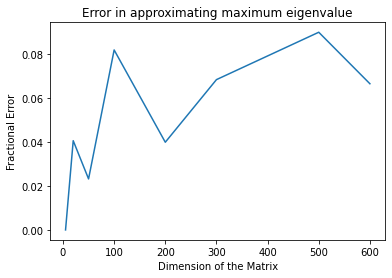

In [6]:
def Error(Estimates, dims):
    S = len(dims)
    X = torch.tensor(dims)
    Y = torch.randn(S)
    for i in range(len(dims)):
        expected, actual = Estimates[i]
        error = (expected - actual) / actual
        error = error.abs()
        Y[i] = error.item()
    return Y, X

Y, X = Error(estimate, n_val)
Y = Y.numpy()
X = X.numpy()
from matplotlib import pyplot as plt
plt.title('Error in approximating maximum eigenvalue')
plt.ylabel('Fractional Error')
plt.xlabel('Dimension of the Matrix')
plt.plot(X, Y)
plt.savefig('error.png', dpi = 300, bbox_inches = 'tight')
plt.show()

<p> Lipschitz constant for \(f(x) = ||\mathcal{A}x - b||^{2}\) is given by \(L_{f} = 2\lambda_{\mathrm{max}}(A^{T}A)\) </p>

Error in approximation used - \begin{align*}\displaystyle \mathrm{Err} = \frac{|L_{\mathrm{act}} - L_{\mathrm{est}}|}{L_{\mathrm{act}}}\end{align*}

In [7]:
# Estimation of optimal solutions of ||Ax - b|| ^ 2 + ||x||_{1}
import torch.optim as optim
import math
n = 500
lam = 0.5
X = torch.randn(n)
X.requires_grad_(True)
A = torch.randn(n, n)
b = torch.randn(n, )
sigma = torch.mm(A.t(), A)
eig = torch.symeig(sigma, eigenvectors = False)
step_size = 0.8 * 1 / eig[0].max()
optimizer = optim.SGD([X], lr = 0.0001, momentum = 0.9)
max_iter = 3000

# Objective function 
def objective(X):
    matrix = torch.matmul(A, X) - b
    term_1 = torch.norm(matrix)
    term_1 = term_1 * term_1
    return term_1 + lam * X.abs().sum()

# Compute the expression p_L(y_k)
def p(y, Lip):
    step_size = 1 / Lip
    grad = 2 * torch.matmul(A.t(), torch.matmul(A, y) - b)
    y = y - step_size * grad
    y = soft_threshold(y, step_size * lam)
    return y

# Upper Bound in the QUB inequality
def Q(x, y, Lipschitz):
    norm = torch.norm(torch.matmul(A, y) - b)
    f_y = norm * norm
    term_1 = f_y
    
    grad = 2 * (torch.matmul(A, y) - b)
    inner_prod = torch.matmul((x - y).t(), grad)
    term_2 = inner_prod
    
    L = Lipschitz
    term_3 = L / 2. * (torch.matmul((x - y).t(), (x - y)))
    
    term_4 = lam * x.abs().sum()
    
    return term_1 + term_2 + term_3 + term_4

# Backtracking step
def find(y, L_curr):
    power = 0
    L_now = L_curr
    while True:
        p_L = p(y, L_now)
        if objective(p_L).item() <= Q(p_L, y, L_now).item():
#             print("Found at power = {}".format(power))
            break
        power += 1
        L_now = L_now * eta
    return power, L_now

# Soft thresholding operator
def soft_threshold(v, lam):
    return torch.sign(v) * torch.max(v.abs() - lam, torch.zeros(v.shape[0], ))


##### Description of functions used
\begin{align*}f(x) = ||\mathcal{A}x - b|| ^ {2}\end{align*}
\begin{align*}\mathrm{Objective\,Function} - ||\mathcal{A}x - b||^{2} + \lambda ||x||_{1}\end{align*}
\begin{align*}\mathrm{Soft\,\,Thresholding \,\, Operator\,} \mathcal{T}_{\epsilon}(x) = \mathrm{sgn}(x)\max(x - \epsilon, 0)\end{align*}
\begin{align*}Q(x, y, L) = f(y) + \langle x - y, \nabla f(y)\rangle + \frac{L}{2}||x - y||^{2} + \lambda ||x|_{1}\end{align*}
\begin{align*}p_{L}(y) = \mathrm{argmin}_{x} Q(x, y, L) = \mathcal{T}_{\frac{\lambda}{L}}(y - \frac{1}{L}\nabla f(y))\end{align*}

In [8]:
# Backtracking approach for ISTA
ista_back = []
x_curr = torch.randn(n, )
y_curr =  x_curr
L_curr = 5.96
t = 1
eta = 1.7
back = 0
# 5.96, 1.7 leads to convergence in ISTA

for i in range(max_iter):
    loss = objective(x_curr)
    print("Loss is : {} Lipschitz constant is : {}".format(loss, L_curr))
    ista_back.append(loss)
    L_curr = find(x_curr, L_curr)[1]
    x_curr = p(x_curr, L_curr)

Loss is : 241435.875 Lipschitz constant is : 5.96
Loss is : 321524.0 Lipschitz constant is : 1201.5323646676038
Loss is : 900132.4375 Lipschitz constant is : 1201.5323646676038
Loss is : 3077366.5 Lipschitz constant is : 1201.5323646676038
Loss is : 11499300.0 Lipschitz constant is : 1201.5323646676038
Loss is : 45598548.0 Lipschitz constant is : 1201.5323646676038
Loss is : 28578386.0 Lipschitz constant is : 2042.6050199349265
Loss is : 19580022.0 Lipschitz constant is : 2042.6050199349265
Loss is : 14323672.0 Lipschitz constant is : 2042.6050199349265
Loss is : 10971254.0 Lipschitz constant is : 2042.6050199349265
Loss is : 8667463.0 Lipschitz constant is : 2042.6050199349265
Loss is : 6988111.0 Lipschitz constant is : 2042.6050199349265
Loss is : 5709394.0 Lipschitz constant is : 2042.6050199349265
Loss is : 4705355.0 Lipschitz constant is : 2042.6050199349265
Loss is : 3900239.75 Lipschitz constant is : 2042.6050199349265
Loss is : 3245395.5 Lipschitz constant is : 2042.60501993492

Loss is : 46.58820343017578 Lipschitz constant is : 2042.6050199349265
Loss is : 46.54661560058594 Lipschitz constant is : 2042.6050199349265
Loss is : 46.5052490234375 Lipschitz constant is : 2042.6050199349265
Loss is : 46.46412658691406 Lipschitz constant is : 2042.6050199349265
Loss is : 46.42320251464844 Lipschitz constant is : 2042.6050199349265
Loss is : 46.38246536254883 Lipschitz constant is : 2042.6050199349265
Loss is : 46.341949462890625 Lipschitz constant is : 2042.6050199349265
Loss is : 46.301597595214844 Lipschitz constant is : 2042.6050199349265
Loss is : 46.261436462402344 Lipschitz constant is : 2042.6050199349265
Loss is : 46.22145080566406 Lipschitz constant is : 2042.6050199349265
Loss is : 46.181644439697266 Lipschitz constant is : 2042.6050199349265
Loss is : 46.14203643798828 Lipschitz constant is : 2042.6050199349265
Loss is : 46.10260772705078 Lipschitz constant is : 2042.6050199349265
Loss is : 46.06334686279297 Lipschitz constant is : 2042.6050199349265
Los

Loss is : 39.375099182128906 Lipschitz constant is : 2042.6050199349265
Loss is : 39.36676025390625 Lipschitz constant is : 2042.6050199349265
Loss is : 39.35844802856445 Lipschitz constant is : 2042.6050199349265
Loss is : 39.350189208984375 Lipschitz constant is : 2042.6050199349265
Loss is : 39.341949462890625 Lipschitz constant is : 2042.6050199349265
Loss is : 39.33373260498047 Lipschitz constant is : 2042.6050199349265
Loss is : 39.32554626464844 Lipschitz constant is : 2042.6050199349265
Loss is : 39.317405700683594 Lipschitz constant is : 2042.6050199349265
Loss is : 39.30927658081055 Lipschitz constant is : 2042.6050199349265
Loss is : 39.301170349121094 Lipschitz constant is : 2042.6050199349265
Loss is : 39.293094635009766 Lipschitz constant is : 2042.6050199349265
Loss is : 39.285057067871094 Lipschitz constant is : 2042.6050199349265
Loss is : 39.27701950073242 Lipschitz constant is : 2042.6050199349265
Loss is : 39.26901626586914 Lipschitz constant is : 2042.6050199349265

Loss is : 37.50893020629883 Lipschitz constant is : 2042.6050199349265
Loss is : 37.50596618652344 Lipschitz constant is : 2042.6050199349265
Loss is : 37.50301742553711 Lipschitz constant is : 2042.6050199349265
Loss is : 37.50007247924805 Lipschitz constant is : 2042.6050199349265
Loss is : 37.49713134765625 Lipschitz constant is : 2042.6050199349265
Loss is : 37.494205474853516 Lipschitz constant is : 2042.6050199349265
Loss is : 37.49125671386719 Lipschitz constant is : 2042.6050199349265
Loss is : 37.48832702636719 Lipschitz constant is : 2042.6050199349265
Loss is : 37.485408782958984 Lipschitz constant is : 2042.6050199349265
Loss is : 37.48248291015625 Lipschitz constant is : 2042.6050199349265
Loss is : 37.47956848144531 Lipschitz constant is : 2042.6050199349265
Loss is : 37.47663879394531 Lipschitz constant is : 2042.6050199349265
Loss is : 37.47372055053711 Lipschitz constant is : 2042.6050199349265
Loss is : 37.470802307128906 Lipschitz constant is : 2042.6050199349265
Los

Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.

Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.

Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.

Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.3889265
Loss is : 37.227970123291016 Lipschitz constant is : 5791008381.

Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222

Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222.213999
Loss is : 37.227970123291016 Lipschitz constant is : 16736014222

In [9]:
objective(X)
len(ista_back)

3000

In [10]:
# Custom Optimizer in Pytorch
pc_loss = []
epochs = 0
eps = 0.00000001
for i in range(max_iter):
    optimizer.zero_grad()
    loss = objective(X)
    pc_loss.append(loss)
    loss_prev = loss
    loss.backward()
    print("Current loss is : {} at iteration : {}".format(loss, epochs))
    epochs += 1
    optimizer.step()
#  For testing number of iterations taken for reaching a certain threshold level
#     loss_new = objective(X)
#     frac = (loss_prev - loss_new) / loss_prev
#     frac = frac.abs()
#     if frac.item() < eps:
#         break

Current loss is : 261975.71875 at iteration : 0
Current loss is : 169637.625 at iteration : 1
Current loss is : 73651.53125 at iteration : 2
Current loss is : 41238.62890625 at iteration : 3
Current loss is : 62880.05859375 at iteration : 4
Current loss is : 87361.96875 at iteration : 5
Current loss is : 85309.953125 at iteration : 6
Current loss is : 67637.375 at iteration : 7
Current loss is : 55895.97265625 at iteration : 8
Current loss is : 53888.2421875 at iteration : 9
Current loss is : 51165.3828125 at iteration : 10
Current loss is : 42296.9140625 at iteration : 11
Current loss is : 33075.21484375 at iteration : 12
Current loss is : 30133.978515625 at iteration : 13
Current loss is : 31953.861328125 at iteration : 14
Current loss is : 32244.595703125 at iteration : 15
Current loss is : 28304.947265625 at iteration : 16
Current loss is : 22926.236328125 at iteration : 17
Current loss is : 19464.5390625 at iteration : 18
Current loss is : 17984.736328125 at iteration : 19
Current

Current loss is : 43.204002380371094 at iteration : 388
Current loss is : 43.16361999511719 at iteration : 389
Current loss is : 43.12324905395508 at iteration : 390
Current loss is : 43.08313751220703 at iteration : 391
Current loss is : 43.04361343383789 at iteration : 392
Current loss is : 43.004878997802734 at iteration : 393
Current loss is : 42.96630859375 at iteration : 394
Current loss is : 42.92806625366211 at iteration : 395
Current loss is : 42.88990020751953 at iteration : 396
Current loss is : 42.8520393371582 at iteration : 397
Current loss is : 42.814605712890625 at iteration : 398
Current loss is : 42.77738571166992 at iteration : 399
Current loss is : 42.740257263183594 at iteration : 400
Current loss is : 42.70341873168945 at iteration : 401
Current loss is : 42.66691970825195 at iteration : 402
Current loss is : 42.63044357299805 at iteration : 403
Current loss is : 42.594200134277344 at iteration : 404
Current loss is : 42.55824661254883 at iteration : 405
Current l

Current loss is : 36.87559509277344 at iteration : 840
Current loss is : 36.873477935791016 at iteration : 841
Current loss is : 36.87129211425781 at iteration : 842
Current loss is : 36.86917495727539 at iteration : 843
Current loss is : 36.86697006225586 at iteration : 844
Current loss is : 36.864994049072266 at iteration : 845
Current loss is : 36.86290740966797 at iteration : 846
Current loss is : 36.8607063293457 at iteration : 847
Current loss is : 36.85866165161133 at iteration : 848
Current loss is : 36.85661315917969 at iteration : 849
Current loss is : 36.85447692871094 at iteration : 850
Current loss is : 36.85239028930664 at iteration : 851
Current loss is : 36.85038375854492 at iteration : 852
Current loss is : 36.84843444824219 at iteration : 853
Current loss is : 36.84632873535156 at iteration : 854
Current loss is : 36.844215393066406 at iteration : 855
Current loss is : 36.84223175048828 at iteration : 856
Current loss is : 36.840179443359375 at iteration : 857
Current

Current loss is : 36.3644905090332 at iteration : 1405
Current loss is : 36.36408996582031 at iteration : 1406
Current loss is : 36.36378860473633 at iteration : 1407
Current loss is : 36.36378479003906 at iteration : 1408
Current loss is : 36.36347961425781 at iteration : 1409
Current loss is : 36.363059997558594 at iteration : 1410
Current loss is : 36.362876892089844 at iteration : 1411
Current loss is : 36.36275100708008 at iteration : 1412
Current loss is : 36.362449645996094 at iteration : 1413
Current loss is : 36.362205505371094 at iteration : 1414
Current loss is : 36.361968994140625 at iteration : 1415
Current loss is : 36.36174011230469 at iteration : 1416
Current loss is : 36.36152648925781 at iteration : 1417
Current loss is : 36.361358642578125 at iteration : 1418
Current loss is : 36.3612060546875 at iteration : 1419
Current loss is : 36.36090087890625 at iteration : 1420
Current loss is : 36.36061477661133 at iteration : 1421
Current loss is : 36.36051559448242 at itera

Current loss is : 36.33180618286133 at iteration : 1571
Current loss is : 36.33169937133789 at iteration : 1572
Current loss is : 36.331661224365234 at iteration : 1573
Current loss is : 36.33167266845703 at iteration : 1574
Current loss is : 36.33148956298828 at iteration : 1575
Current loss is : 36.331199645996094 at iteration : 1576
Current loss is : 36.33110427856445 at iteration : 1577
Current loss is : 36.331092834472656 at iteration : 1578
Current loss is : 36.330909729003906 at iteration : 1579
Current loss is : 36.33074188232422 at iteration : 1580
Current loss is : 36.33070373535156 at iteration : 1581
Current loss is : 36.33062744140625 at iteration : 1582
Current loss is : 36.33060073852539 at iteration : 1583
Current loss is : 36.33056640625 at iteration : 1584
Current loss is : 36.330326080322266 at iteration : 1585
Current loss is : 36.330116271972656 at iteration : 1586
Current loss is : 36.330055236816406 at iteration : 1587
Current loss is : 36.32990264892578 at itera

Current loss is : 36.31073760986328 at iteration : 2072
Current loss is : 36.310546875 at iteration : 2073
Current loss is : 36.31041717529297 at iteration : 2074
Current loss is : 36.31049728393555 at iteration : 2075
Current loss is : 36.31053161621094 at iteration : 2076
Current loss is : 36.31062698364258 at iteration : 2077
Current loss is : 36.31053161621094 at iteration : 2078
Current loss is : 36.31049346923828 at iteration : 2079
Current loss is : 36.31058883666992 at iteration : 2080
Current loss is : 36.310462951660156 at iteration : 2081
Current loss is : 36.31047821044922 at iteration : 2082
Current loss is : 36.31052017211914 at iteration : 2083
Current loss is : 36.31039047241211 at iteration : 2084
Current loss is : 36.31040573120117 at iteration : 2085
Current loss is : 36.310394287109375 at iteration : 2086
Current loss is : 36.310394287109375 at iteration : 2087
Current loss is : 36.310333251953125 at iteration : 2088
Current loss is : 36.310272216796875 at iteration

Current loss is : 36.30844497680664 at iteration : 2550
Current loss is : 36.308380126953125 at iteration : 2551
Current loss is : 36.30855941772461 at iteration : 2552
Current loss is : 36.30842208862305 at iteration : 2553
Current loss is : 36.308448791503906 at iteration : 2554
Current loss is : 36.308448791503906 at iteration : 2555
Current loss is : 36.30857467651367 at iteration : 2556
Current loss is : 36.308475494384766 at iteration : 2557
Current loss is : 36.308448791503906 at iteration : 2558
Current loss is : 36.30839538574219 at iteration : 2559
Current loss is : 36.308528900146484 at iteration : 2560
Current loss is : 36.308345794677734 at iteration : 2561
Current loss is : 36.308345794677734 at iteration : 2562
Current loss is : 36.30842971801758 at iteration : 2563
Current loss is : 36.308494567871094 at iteration : 2564
Current loss is : 36.308536529541016 at iteration : 2565
Current loss is : 36.30846405029297 at iteration : 2566
Current loss is : 36.308433532714844 a

In [11]:
X_final = X

estimate, actual = Approximation(A)
L_app = 2 * estimate
L = 2 * eig[0].max()
step_size = 1 / L
L, L_app, len(pc_loss)

(tensor(3950.3452), tensor(3586.8481), 3000)

In [12]:
# ISTA without backtracking
ista_app = []
ista_loss = []
x = torch.randn(n, )
print(objective(x))

ista = 0
# while True:
for which in range(2):
    x = torch.randn(n, )
    
    if which:
        step_size = 1 / L
    else :
        step_size = 1 / L_app

    for i in range(max_iter):
        loss = objective(x)
        if which :
            ista_loss.append(loss)
        else :
            ista_app.append(loss)
        loss_prev = loss
        print("Loss is : {} at iteration : {}".format(loss, i))
        ista += 1
        grad = 2 * torch.matmul(A.t(), torch.matmul(A, x) - b)
        x = x - step_size * grad
        x = soft_threshold(x, step_size * lam)
    
    
# For testing number of iterations taken for reaching a certain threshold level
#     loss_new = objective(x)
#     frac = (loss_prev - loss_new) / loss_prev
#     frac = frac.abs()
#     if frac.item() < eps:
#         break

tensor(230375.8594)
Loss is : 274193.4375 at iteration : 0
Loss is : 71846.1875 at iteration : 1
Loss is : 36045.109375 at iteration : 2
Loss is : 22578.001953125 at iteration : 3
Loss is : 15844.0654296875 at iteration : 4
Loss is : 11914.994140625 at iteration : 5
Loss is : 9390.0673828125 at iteration : 6
Loss is : 7653.47802734375 at iteration : 7
Loss is : 6396.5986328125 at iteration : 8
Loss is : 5450.20263671875 at iteration : 9
Loss is : 4714.86083984375 at iteration : 10
Loss is : 4128.80126953125 at iteration : 11
Loss is : 3652.267333984375 at iteration : 12
Loss is : 3258.2841796875 at iteration : 13
Loss is : 2927.9716796875 at iteration : 14
Loss is : 2647.724853515625 at iteration : 15
Loss is : 2407.603271484375 at iteration : 16
Loss is : 2200.055419921875 at iteration : 17
Loss is : 2019.3485107421875 at iteration : 18
Loss is : 1860.9613037109375 at iteration : 19
Loss is : 1721.3448486328125 at iteration : 20
Loss is : 1597.6175537109375 at iteration : 21
Loss is :

Loss is : 49.242347717285156 at iteration : 650
Loss is : 49.20775604248047 at iteration : 651
Loss is : 49.17326736450195 at iteration : 652
Loss is : 49.138858795166016 at iteration : 653
Loss is : 49.104522705078125 at iteration : 654
Loss is : 49.070228576660156 at iteration : 655
Loss is : 49.0360107421875 at iteration : 656
Loss is : 49.00188446044922 at iteration : 657
Loss is : 48.96778869628906 at iteration : 658
Loss is : 48.933815002441406 at iteration : 659
Loss is : 48.899864196777344 at iteration : 660
Loss is : 48.86599349975586 at iteration : 661
Loss is : 48.832176208496094 at iteration : 662
Loss is : 48.798439025878906 at iteration : 663
Loss is : 48.76475524902344 at iteration : 664
Loss is : 48.73115539550781 at iteration : 665
Loss is : 48.69762420654297 at iteration : 666
Loss is : 48.66413497924805 at iteration : 667
Loss is : 48.6307258605957 at iteration : 668
Loss is : 48.59737014770508 at iteration : 669
Loss is : 48.56407928466797 at iteration : 670
Loss is

Loss is : 38.17992401123047 at iteration : 1329
Loss is : 38.175262451171875 at iteration : 1330
Loss is : 38.17060470581055 at iteration : 1331
Loss is : 38.16594696044922 at iteration : 1332
Loss is : 38.16131591796875 at iteration : 1333
Loss is : 38.15668487548828 at iteration : 1334
Loss is : 38.152069091796875 at iteration : 1335
Loss is : 38.1474494934082 at iteration : 1336
Loss is : 38.14284896850586 at iteration : 1337
Loss is : 38.13825225830078 at iteration : 1338
Loss is : 38.13365173339844 at iteration : 1339
Loss is : 38.12907028198242 at iteration : 1340
Loss is : 38.12449645996094 at iteration : 1341
Loss is : 38.11994171142578 at iteration : 1342
Loss is : 38.11549758911133 at iteration : 1343
Loss is : 38.11111831665039 at iteration : 1344
Loss is : 38.106773376464844 at iteration : 1345
Loss is : 38.10247039794922 at iteration : 1346
Loss is : 38.098175048828125 at iteration : 1347
Loss is : 38.093894958496094 at iteration : 1348
Loss is : 38.08964920043945 at itera

Loss is : 36.7673225402832 at iteration : 2043
Loss is : 36.76646423339844 at iteration : 2044
Loss is : 36.76560974121094 at iteration : 2045
Loss is : 36.76475524902344 at iteration : 2046
Loss is : 36.76390075683594 at iteration : 2047
Loss is : 36.7630500793457 at iteration : 2048
Loss is : 36.7621955871582 at iteration : 2049
Loss is : 36.76136016845703 at iteration : 2050
Loss is : 36.7605094909668 at iteration : 2051
Loss is : 36.759674072265625 at iteration : 2052
Loss is : 36.758846282958984 at iteration : 2053
Loss is : 36.75800704956055 at iteration : 2054
Loss is : 36.757179260253906 at iteration : 2055
Loss is : 36.7563591003418 at iteration : 2056
Loss is : 36.75553512573242 at iteration : 2057
Loss is : 36.754730224609375 at iteration : 2058
Loss is : 36.75391387939453 at iteration : 2059
Loss is : 36.753089904785156 at iteration : 2060
Loss is : 36.752281188964844 at iteration : 2061
Loss is : 36.75148010253906 at iteration : 2062
Loss is : 36.750675201416016 at iterati

Loss is : 36.4525260925293 at iteration : 2817
Loss is : 36.45234680175781 at iteration : 2818
Loss is : 36.45216369628906 at iteration : 2819
Loss is : 36.45197296142578 at iteration : 2820
Loss is : 36.45179748535156 at iteration : 2821
Loss is : 36.45162582397461 at iteration : 2822
Loss is : 36.451454162597656 at iteration : 2823
Loss is : 36.451271057128906 at iteration : 2824
Loss is : 36.451087951660156 at iteration : 2825
Loss is : 36.45091247558594 at iteration : 2826
Loss is : 36.45074462890625 at iteration : 2827
Loss is : 36.4505615234375 at iteration : 2828
Loss is : 36.45037841796875 at iteration : 2829
Loss is : 36.45021057128906 at iteration : 2830
Loss is : 36.45003128051758 at iteration : 2831
Loss is : 36.449859619140625 at iteration : 2832
Loss is : 36.44967269897461 at iteration : 2833
Loss is : 36.449501037597656 at iteration : 2834
Loss is : 36.44932556152344 at iteration : 2835
Loss is : 36.44915008544922 at iteration : 2836
Loss is : 36.44898986816406 at iterat

Loss is : 55.52354431152344 at iteration : 560
Loss is : 55.45661163330078 at iteration : 561
Loss is : 55.389984130859375 at iteration : 562
Loss is : 55.32384490966797 at iteration : 563
Loss is : 55.25823211669922 at iteration : 564
Loss is : 55.19297790527344 at iteration : 565
Loss is : 55.128028869628906 at iteration : 566
Loss is : 55.06336975097656 at iteration : 567
Loss is : 54.99897003173828 at iteration : 568
Loss is : 54.93483352661133 at iteration : 569
Loss is : 54.87098693847656 at iteration : 570
Loss is : 54.80736541748047 at iteration : 571
Loss is : 54.743995666503906 at iteration : 572
Loss is : 54.68095016479492 at iteration : 573
Loss is : 54.61819076538086 at iteration : 574
Loss is : 54.55609130859375 at iteration : 575
Loss is : 54.494346618652344 at iteration : 576
Loss is : 54.432979583740234 at iteration : 577
Loss is : 54.37190246582031 at iteration : 578
Loss is : 54.31111145019531 at iteration : 579
Loss is : 54.25056838989258 at iteration : 580
Loss is 

Loss is : 39.22343444824219 at iteration : 1298
Loss is : 39.217742919921875 at iteration : 1299
Loss is : 39.212039947509766 at iteration : 1300
Loss is : 39.20636749267578 at iteration : 1301
Loss is : 39.20070266723633 at iteration : 1302
Loss is : 39.195045471191406 at iteration : 1303
Loss is : 39.18940734863281 at iteration : 1304
Loss is : 39.18375778198242 at iteration : 1305
Loss is : 39.17812728881836 at iteration : 1306
Loss is : 39.17259216308594 at iteration : 1307
Loss is : 39.16709518432617 at iteration : 1308
Loss is : 39.161659240722656 at iteration : 1309
Loss is : 39.156219482421875 at iteration : 1310
Loss is : 39.15083312988281 at iteration : 1311
Loss is : 39.14546585083008 at iteration : 1312
Loss is : 39.14011001586914 at iteration : 1313
Loss is : 39.13475799560547 at iteration : 1314
Loss is : 39.12945556640625 at iteration : 1315
Loss is : 39.124168395996094 at iteration : 1316
Loss is : 39.11888122558594 at iteration : 1317
Loss is : 39.113643646240234 at it

Loss is : 37.31618881225586 at iteration : 2001
Loss is : 37.31475830078125 at iteration : 2002
Loss is : 37.313331604003906 at iteration : 2003
Loss is : 37.31190490722656 at iteration : 2004
Loss is : 37.31047821044922 at iteration : 2005
Loss is : 37.309059143066406 at iteration : 2006
Loss is : 37.30764389038086 at iteration : 2007
Loss is : 37.30622482299805 at iteration : 2008
Loss is : 37.30479049682617 at iteration : 2009
Loss is : 37.30339050292969 at iteration : 2010
Loss is : 37.301971435546875 at iteration : 2011
Loss is : 37.30056381225586 at iteration : 2012
Loss is : 37.29914093017578 at iteration : 2013
Loss is : 37.29774475097656 at iteration : 2014
Loss is : 37.29634094238281 at iteration : 2015
Loss is : 37.294944763183594 at iteration : 2016
Loss is : 37.293540954589844 at iteration : 2017
Loss is : 37.292144775390625 at iteration : 2018
Loss is : 37.2907600402832 at iteration : 2019
Loss is : 37.28936767578125 at iteration : 2020
Loss is : 37.28797912597656 at iter

Loss is : 36.6088981628418 at iteration : 2799
Loss is : 36.60845184326172 at iteration : 2800
Loss is : 36.60800552368164 at iteration : 2801
Loss is : 36.60755920410156 at iteration : 2802
Loss is : 36.607112884521484 at iteration : 2803
Loss is : 36.6066780090332 at iteration : 2804
Loss is : 36.60622024536133 at iteration : 2805
Loss is : 36.605777740478516 at iteration : 2806
Loss is : 36.60533142089844 at iteration : 2807
Loss is : 36.60490417480469 at iteration : 2808
Loss is : 36.60445785522461 at iteration : 2809
Loss is : 36.60401153564453 at iteration : 2810
Loss is : 36.60357666015625 at iteration : 2811
Loss is : 36.6031379699707 at iteration : 2812
Loss is : 36.60268783569336 at iteration : 2813
Loss is : 36.602256774902344 at iteration : 2814
Loss is : 36.6018180847168 at iteration : 2815
Loss is : 36.601383209228516 at iteration : 2816
Loss is : 36.6009521484375 at iteration : 2817
Loss is : 36.60051727294922 at iteration : 2818
Loss is : 36.60009002685547 at iteration 

#### Step updates in ISTA
\begin{align*}x_{k} = \mathrm{argmin}\,Q(x, x_{k - 1})\end{align*}


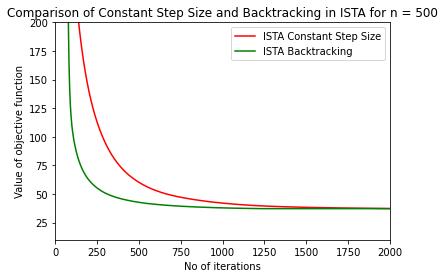

In [13]:
# ISTA without backtracking vs backtracking
x = np.arange(max_iter)
plt.plot(x, ista_loss, 'r', label = 'ISTA Constant Step Size')
plt.plot(x, ista_back, 'g', label = 'ISTA Backtracking')
axes = plt.gca()
axes.set_xlim([0, 2000])
axes.set_ylim([10, 200])
plt.xlabel('No of iterations')
plt.ylabel('Value of objective function')
plt.title('Comparison of Constant Step Size and Backtracking in ISTA for n = {}'.format(n))
plt.legend()
# plt.savefig('ISTA backtracking vs constant step n = {}.png'.format(n))
plt.show()

In [14]:
# FISTA without backtracking

# Some time step update rules
def g(t):
    return (1 + math.sqrt(1 + 4 * pow(t, 2))) / 2.

def h(t):
    return (1 + math.sqrt(1 + pow(t, 2))) / 2.

def m(t):
    return (1 + t) / 2.

fista_loss = []
fista_app = []
fista_new_time = []
fista_linear = []
z = torch.randn(n, )
y = z
t = 1
fista = 0
for which in range(0, 3):
    z = torch.randn(n, )
    y = z
    t = 1
#     if which:
#         step_size = 1 / L
#     else :
#         step_size = 1 / L_app
    for i in range(max_iter):
    # Compute p_L(y)
        loss = objective(z)
#         if which:
#             fista_loss.append(loss)
#         else :
#             fista_app.append(loss)
        if which == 2: 
            fista_loss.append(loss)
        elif which == 1 :
            fista_new_time.append(loss)
        else :
            fista_linear.append(loss)
        loss_prev = loss
        print("Loss is : {} at iteration : {}".format(loss, fista))
        fista += 1
        z_prev = z
        grad = 2 * torch.matmul(A.t(), torch.matmul(A, y) - b)
        y = y - step_size * grad
        y = soft_threshold(y, step_size * lam)
        z_new = y
        z = z_new

        if which == 2: 
            t_new = g(t)
        elif which == 1:
            t_new = h(t)
        else :
            t_new = m(t)
        t_prev = t
        t = t_new

        y = z_new + (t_prev - 1) / t_new * (z_new - z_prev)

    
#     loss_new = objective(z)
#     frac = (loss_prev - loss_new) / loss_prev
#     frac = frac.abs()
#     if frac.item() < eps:
#         break

Loss is : 205313.734375 at iteration : 0
Loss is : 75274.265625 at iteration : 1
Loss is : 41272.6171875 at iteration : 2
Loss is : 26327.248046875 at iteration : 3
Loss is : 18419.353515625 at iteration : 4
Loss is : 13739.271484375 at iteration : 5
Loss is : 10738.888671875 at iteration : 6
Loss is : 8695.2138671875 at iteration : 7
Loss is : 7235.77783203125 at iteration : 8
Loss is : 6153.451171875 at iteration : 9
Loss is : 5325.88818359375 at iteration : 10
Loss is : 4676.8701171875 at iteration : 11
Loss is : 4156.87353515625 at iteration : 12
Loss is : 3732.5 at iteration : 13
Loss is : 3380.62646484375 at iteration : 14
Loss is : 3084.882568359375 at iteration : 15
Loss is : 2833.316650390625 at iteration : 16
Loss is : 2617.100830078125 at iteration : 17
Loss is : 2429.52587890625 at iteration : 18
Loss is : 2265.47265625 at iteration : 19
Loss is : 2120.922119140625 at iteration : 20
Loss is : 1992.7216796875 at iteration : 21
Loss is : 1878.29345703125 at iteration : 22
Los

Loss is : 61.398101806640625 at iteration : 523
Loss is : 61.30413818359375 at iteration : 524
Loss is : 61.21058654785156 at iteration : 525
Loss is : 61.11737823486328 at iteration : 526
Loss is : 61.02519226074219 at iteration : 527
Loss is : 60.933448791503906 at iteration : 528
Loss is : 60.842594146728516 at iteration : 529
Loss is : 60.75231170654297 at iteration : 530
Loss is : 60.66239929199219 at iteration : 531
Loss is : 60.5728874206543 at iteration : 532
Loss is : 60.483734130859375 at iteration : 533
Loss is : 60.394935607910156 at iteration : 534
Loss is : 60.30651092529297 at iteration : 535
Loss is : 60.218849182128906 at iteration : 536
Loss is : 60.13209533691406 at iteration : 537
Loss is : 60.04576873779297 at iteration : 538
Loss is : 59.95981216430664 at iteration : 539
Loss is : 59.874229431152344 at iteration : 540
Loss is : 59.78900146484375 at iteration : 541
Loss is : 59.70412826538086 at iteration : 542
Loss is : 59.619598388671875 at iteration : 543
Loss i

Loss is : 40.368812561035156 at iteration : 1155
Loss is : 40.3586540222168 at iteration : 1156
Loss is : 40.3485221862793 at iteration : 1157
Loss is : 40.33839416503906 at iteration : 1158
Loss is : 40.328304290771484 at iteration : 1159
Loss is : 40.318214416503906 at iteration : 1160
Loss is : 40.30814743041992 at iteration : 1161
Loss is : 40.298095703125 at iteration : 1162
Loss is : 40.2880859375 at iteration : 1163
Loss is : 40.278106689453125 at iteration : 1164
Loss is : 40.26813507080078 at iteration : 1165
Loss is : 40.258182525634766 at iteration : 1166
Loss is : 40.248260498046875 at iteration : 1167
Loss is : 40.23834991455078 at iteration : 1168
Loss is : 40.228572845458984 at iteration : 1169
Loss is : 40.218910217285156 at iteration : 1170
Loss is : 40.20940017700195 at iteration : 1171
Loss is : 40.19996643066406 at iteration : 1172
Loss is : 40.19059753417969 at iteration : 1173
Loss is : 40.181278228759766 at iteration : 1174
Loss is : 40.17197799682617 at iteratio

Loss is : 37.065982818603516 at iteration : 1900
Loss is : 37.06440734863281 at iteration : 1901
Loss is : 37.0628662109375 at iteration : 1902
Loss is : 37.061317443847656 at iteration : 1903
Loss is : 37.05978775024414 at iteration : 1904
Loss is : 37.05824661254883 at iteration : 1905
Loss is : 37.05672073364258 at iteration : 1906
Loss is : 37.05520248413086 at iteration : 1907
Loss is : 37.053672790527344 at iteration : 1908
Loss is : 37.05215835571289 at iteration : 1909
Loss is : 37.05064010620117 at iteration : 1910
Loss is : 37.04914093017578 at iteration : 1911
Loss is : 37.047637939453125 at iteration : 1912
Loss is : 37.046142578125 at iteration : 1913
Loss is : 37.04464340209961 at iteration : 1914
Loss is : 37.04313659667969 at iteration : 1915
Loss is : 37.041656494140625 at iteration : 1916
Loss is : 37.0401611328125 at iteration : 1917
Loss is : 37.038700103759766 at iteration : 1918
Loss is : 37.03721618652344 at iteration : 1919
Loss is : 37.03574752807617 at iterati

Loss is : 36.51557540893555 at iteration : 2603
Loss is : 36.515235900878906 at iteration : 2604
Loss is : 36.5149040222168 at iteration : 2605
Loss is : 36.5145378112793 at iteration : 2606
Loss is : 36.51420211791992 at iteration : 2607
Loss is : 36.51386642456055 at iteration : 2608
Loss is : 36.51350402832031 at iteration : 2609
Loss is : 36.513179779052734 at iteration : 2610
Loss is : 36.51285171508789 at iteration : 2611
Loss is : 36.512489318847656 at iteration : 2612
Loss is : 36.51216125488281 at iteration : 2613
Loss is : 36.51182556152344 at iteration : 2614
Loss is : 36.51148986816406 at iteration : 2615
Loss is : 36.51115036010742 at iteration : 2616
Loss is : 36.51080322265625 at iteration : 2617
Loss is : 36.510467529296875 at iteration : 2618
Loss is : 36.5101318359375 at iteration : 2619
Loss is : 36.50981140136719 at iteration : 2620
Loss is : 36.50947570800781 at iteration : 2621
Loss is : 36.50914001464844 at iteration : 2622
Loss is : 36.5088005065918 at iteration

Loss is : 36.42295455932617 at iteration : 2963
Loss is : 36.42280197143555 at iteration : 2964
Loss is : 36.42262649536133 at iteration : 2965
Loss is : 36.422462463378906 at iteration : 2966
Loss is : 36.42229461669922 at iteration : 2967
Loss is : 36.42212677001953 at iteration : 2968
Loss is : 36.421958923339844 at iteration : 2969
Loss is : 36.421791076660156 at iteration : 2970
Loss is : 36.42161560058594 at iteration : 2971
Loss is : 36.42144775390625 at iteration : 2972
Loss is : 36.42128372192383 at iteration : 2973
Loss is : 36.42111587524414 at iteration : 2974
Loss is : 36.42095184326172 at iteration : 2975
Loss is : 36.42079162597656 at iteration : 2976
Loss is : 36.420623779296875 at iteration : 2977
Loss is : 36.420448303222656 at iteration : 2978
Loss is : 36.420291900634766 at iteration : 2979
Loss is : 36.420127868652344 at iteration : 2980
Loss is : 36.41996383666992 at iteration : 2981
Loss is : 36.4197998046875 at iteration : 2982
Loss is : 36.41964340209961 at ite

Loss is : 82.60884857177734 at iteration : 3267
Loss is : 82.42227172851562 at iteration : 3268
Loss is : 82.23776245117188 at iteration : 3269
Loss is : 82.0548324584961 at iteration : 3270
Loss is : 81.8734130859375 at iteration : 3271
Loss is : 81.69346618652344 at iteration : 3272
Loss is : 81.51496887207031 at iteration : 3273
Loss is : 81.33782958984375 at iteration : 3274
Loss is : 81.16213989257812 at iteration : 3275
Loss is : 80.98776245117188 at iteration : 3276
Loss is : 80.81472778320312 at iteration : 3277
Loss is : 80.64303588867188 at iteration : 3278
Loss is : 80.47264099121094 at iteration : 3279
Loss is : 80.30351257324219 at iteration : 3280
Loss is : 80.13566589355469 at iteration : 3281
Loss is : 79.9691162109375 at iteration : 3282
Loss is : 79.80375671386719 at iteration : 3283
Loss is : 79.63980102539062 at iteration : 3284
Loss is : 79.47724914550781 at iteration : 3285
Loss is : 79.31594848632812 at iteration : 3286
Loss is : 79.1558609008789 at iteration : 3

Loss is : 46.39656066894531 at iteration : 3872
Loss is : 46.37258529663086 at iteration : 3873
Loss is : 46.34861373901367 at iteration : 3874
Loss is : 46.32464599609375 at iteration : 3875
Loss is : 46.300743103027344 at iteration : 3876
Loss is : 46.27685546875 at iteration : 3877
Loss is : 46.25300598144531 at iteration : 3878
Loss is : 46.22917556762695 at iteration : 3879
Loss is : 46.205379486083984 at iteration : 3880
Loss is : 46.18159484863281 at iteration : 3881
Loss is : 46.15785217285156 at iteration : 3882
Loss is : 46.13413619995117 at iteration : 3883
Loss is : 46.110443115234375 at iteration : 3884
Loss is : 46.086761474609375 at iteration : 3885
Loss is : 46.063106536865234 at iteration : 3886
Loss is : 46.03950500488281 at iteration : 3887
Loss is : 46.015926361083984 at iteration : 3888
Loss is : 45.992401123046875 at iteration : 3889
Loss is : 45.96889877319336 at iteration : 3890
Loss is : 45.9454345703125 at iteration : 3891
Loss is : 45.921993255615234 at itera

Loss is : 38.28847885131836 at iteration : 4553
Loss is : 38.283782958984375 at iteration : 4554
Loss is : 38.279083251953125 at iteration : 4555
Loss is : 38.2744140625 at iteration : 4556
Loss is : 38.269737243652344 at iteration : 4557
Loss is : 38.26508712768555 at iteration : 4558
Loss is : 38.260406494140625 at iteration : 4559
Loss is : 38.25575256347656 at iteration : 4560
Loss is : 38.25111389160156 at iteration : 4561
Loss is : 38.2464714050293 at iteration : 4562
Loss is : 38.24184799194336 at iteration : 4563
Loss is : 38.23723220825195 at iteration : 4564
Loss is : 38.232608795166016 at iteration : 4565
Loss is : 38.228004455566406 at iteration : 4566
Loss is : 38.22340774536133 at iteration : 4567
Loss is : 38.21881103515625 at iteration : 4568
Loss is : 38.21421813964844 at iteration : 4569
Loss is : 38.209632873535156 at iteration : 4570
Loss is : 38.20506286621094 at iteration : 4571
Loss is : 38.200496673583984 at iteration : 4572
Loss is : 38.195926666259766 at itera

Loss is : 36.801265716552734 at iteration : 5214
Loss is : 36.80020523071289 at iteration : 5215
Loss is : 36.799137115478516 at iteration : 5216
Loss is : 36.798057556152344 at iteration : 5217
Loss is : 36.79698944091797 at iteration : 5218
Loss is : 36.79591751098633 at iteration : 5219
Loss is : 36.794857025146484 at iteration : 5220
Loss is : 36.793800354003906 at iteration : 5221
Loss is : 36.79273223876953 at iteration : 5222
Loss is : 36.79167175292969 at iteration : 5223
Loss is : 36.79060363769531 at iteration : 5224
Loss is : 36.78955078125 at iteration : 5225
Loss is : 36.78849411010742 at iteration : 5226
Loss is : 36.78744888305664 at iteration : 5227
Loss is : 36.786376953125 at iteration : 5228
Loss is : 36.78533935546875 at iteration : 5229
Loss is : 36.78428649902344 at iteration : 5230
Loss is : 36.78321838378906 at iteration : 5231
Loss is : 36.78218460083008 at iteration : 5232
Loss is : 36.7811279296875 at iteration : 5233
Loss is : 36.780094146728516 at iteration

Loss is : 36.45982360839844 at iteration : 5836
Loss is : 36.45950698852539 at iteration : 5837
Loss is : 36.459171295166016 at iteration : 5838
Loss is : 36.45882797241211 at iteration : 5839
Loss is : 36.45850372314453 at iteration : 5840
Loss is : 36.458168029785156 at iteration : 5841
Loss is : 36.45782470703125 at iteration : 5842
Loss is : 36.457496643066406 at iteration : 5843
Loss is : 36.45716857910156 at iteration : 5844
Loss is : 36.45684051513672 at iteration : 5845
Loss is : 36.45650863647461 at iteration : 5846
Loss is : 36.4561767578125 at iteration : 5847
Loss is : 36.455848693847656 at iteration : 5848
Loss is : 36.455509185791016 at iteration : 5849
Loss is : 36.45518493652344 at iteration : 5850
Loss is : 36.45486831665039 at iteration : 5851
Loss is : 36.45454788208008 at iteration : 5852
Loss is : 36.454246520996094 at iteration : 5853
Loss is : 36.45393753051758 at iteration : 5854
Loss is : 36.453643798828125 at iteration : 5855
Loss is : 36.45334243774414 at ite

Loss is : 36.30997848510742 at iteration : 6535
Loss is : 36.309959411621094 at iteration : 6536
Loss is : 36.30994415283203 at iteration : 6537
Loss is : 36.309940338134766 at iteration : 6538
Loss is : 36.3099365234375 at iteration : 6539
Loss is : 36.3099365234375 at iteration : 6540
Loss is : 36.3099365234375 at iteration : 6541
Loss is : 36.30995178222656 at iteration : 6542
Loss is : 36.3099479675293 at iteration : 6543
Loss is : 36.309967041015625 at iteration : 6544
Loss is : 36.30998229980469 at iteration : 6545
Loss is : 36.31000518798828 at iteration : 6546
Loss is : 36.310035705566406 at iteration : 6547
Loss is : 36.31006622314453 at iteration : 6548
Loss is : 36.31009292602539 at iteration : 6549
Loss is : 36.31013488769531 at iteration : 6550
Loss is : 36.310176849365234 at iteration : 6551
Loss is : 36.310218811035156 at iteration : 6552
Loss is : 36.31025695800781 at iteration : 6553
Loss is : 36.310302734375 at iteration : 6554
Loss is : 36.31033706665039 at iteration

Loss is : 36.30751037597656 at iteration : 7171
Loss is : 36.30752944946289 at iteration : 7172
Loss is : 36.30751419067383 at iteration : 7173
Loss is : 36.307518005371094 at iteration : 7174
Loss is : 36.307518005371094 at iteration : 7175
Loss is : 36.307518005371094 at iteration : 7176
Loss is : 36.30752182006836 at iteration : 7177
Loss is : 36.307518005371094 at iteration : 7178
Loss is : 36.3075065612793 at iteration : 7179
Loss is : 36.307525634765625 at iteration : 7180
Loss is : 36.307525634765625 at iteration : 7181
Loss is : 36.307525634765625 at iteration : 7182
Loss is : 36.307525634765625 at iteration : 7183
Loss is : 36.307525634765625 at iteration : 7184
Loss is : 36.307525634765625 at iteration : 7185
Loss is : 36.30752944946289 at iteration : 7186
Loss is : 36.307525634765625 at iteration : 7187
Loss is : 36.30751419067383 at iteration : 7188
Loss is : 36.307518005371094 at iteration : 7189
Loss is : 36.307525634765625 at iteration : 7190
Loss is : 36.30752944946289 

Loss is : 36.30747604370117 at iteration : 7762
Loss is : 36.307472229003906 at iteration : 7763
Loss is : 36.30748748779297 at iteration : 7764
Loss is : 36.30747985839844 at iteration : 7765
Loss is : 36.307464599609375 at iteration : 7766
Loss is : 36.307491302490234 at iteration : 7767
Loss is : 36.30747985839844 at iteration : 7768
Loss is : 36.307472229003906 at iteration : 7769
Loss is : 36.307472229003906 at iteration : 7770
Loss is : 36.30747985839844 at iteration : 7771
Loss is : 36.30747985839844 at iteration : 7772
Loss is : 36.30747985839844 at iteration : 7773
Loss is : 36.30747604370117 at iteration : 7774
Loss is : 36.30747985839844 at iteration : 7775
Loss is : 36.307472229003906 at iteration : 7776
Loss is : 36.307472229003906 at iteration : 7777
Loss is : 36.30747985839844 at iteration : 7778
Loss is : 36.30746078491211 at iteration : 7779
Loss is : 36.307472229003906 at iteration : 7780
Loss is : 36.30746841430664 at iteration : 7781
Loss is : 36.30747985839844 at i

Loss is : 36.307472229003906 at iteration : 8415
Loss is : 36.307456970214844 at iteration : 8416
Loss is : 36.30746841430664 at iteration : 8417
Loss is : 36.30747604370117 at iteration : 8418
Loss is : 36.30746078491211 at iteration : 8419
Loss is : 36.307464599609375 at iteration : 8420
Loss is : 36.30746078491211 at iteration : 8421
Loss is : 36.30746841430664 at iteration : 8422
Loss is : 36.307456970214844 at iteration : 8423
Loss is : 36.307456970214844 at iteration : 8424
Loss is : 36.307456970214844 at iteration : 8425
Loss is : 36.307456970214844 at iteration : 8426
Loss is : 36.30746078491211 at iteration : 8427
Loss is : 36.30746078491211 at iteration : 8428
Loss is : 36.307472229003906 at iteration : 8429
Loss is : 36.307464599609375 at iteration : 8430
Loss is : 36.307464599609375 at iteration : 8431
Loss is : 36.307472229003906 at iteration : 8432
Loss is : 36.307472229003906 at iteration : 8433
Loss is : 36.307464599609375 at iteration : 8434
Loss is : 36.30746841430664

#### Time step updates used 
\begin{align*} t_{n + 1} = \frac{1 + t_{n}}{2}, t_{n + 1} = \frac{1 + \sqrt{1 + 4t_{n}^{2}}}{2}, t_{n + 1} = \frac{1 + \sqrt{1 + t_{n}^{2}}}{2}\end{align*}

#### Step Updates in FISTA
\begin{align*} y_{k} = x_{k} + \frac{t_{k - 1} - 1}{t_{k}}(x_{k} - x_{k - 1})\end{align*}
\begin{align*}x_{k + 1} = \mathrm{argmin}\,Q(x, y_{k}, L)
\end{align*}
\begin{align*} t_{k + 1} = f(t_n)
\end{align*}

In [15]:
len(fista_linear), len(fista_loss), len(fista_new_time)

(3000, 3000, 3000)

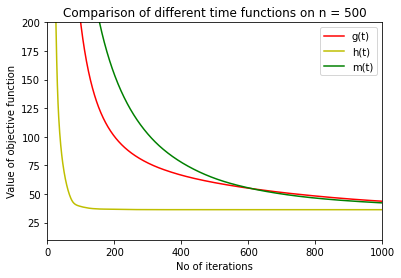

In [16]:
x = np.arange(max_iter)
plt.plot(x, fista_new_time, 'r', label = 'g(t)')
plt.plot(x, fista_loss, 'y', label =  'h(t)')
plt.plot(x, fista_linear, 'g', label =  'm(t)')
axes = plt.gca()
axes.set_xlim([0, 1000])
axes.set_ylim([10, 200])
plt.xlabel('No of iterations')
plt.ylabel('Value of objective function')
plt.title('Comparison of different time functions on n = {}'.format(n))
plt.legend()
# plt.savefig('Comparison on different time functions on n = {}.png'.format(n))
plt.show()

In [17]:
# epochs, ista, fista # Iterations taken till tolerance levels is attained by Pytorchs SGD Optimizer, Ista and Fista 

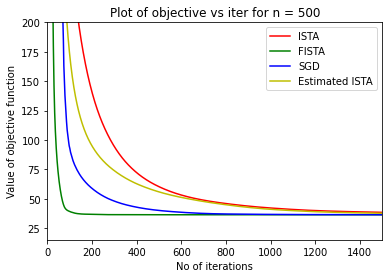

In [18]:
ista_loss = np.array(ista_loss)
fista_loss = np.array(fista_loss)
pc_loss = np.array(pc_loss)
ista_app = np.array(ista_app)
# fista_app = np.array(fista_app)
x = np.arange(max_iter)
plt.plot(x, ista_loss, 'r', label = 'ISTA')
plt.plot(x, fista_loss, 'g', label = 'FISTA')
plt.plot(x, pc_loss, 'b', label = 'SGD')
plt.plot(x, ista_app, 'y', label = 'Estimated ISTA')
# plt.plot(x, fista_app, 'c', label = 'Estimated FISTA')
axes = plt.gca()
axes.set_xlim([0, 1500])
axes.set_ylim([15, 200])
plt.xlabel('No of iterations')
plt.ylabel('Value of objective function')
plt.title('Plot of objective vs iter for n = {}'.format(n))
plt.legend()
# plt.savefig('Estimated n = {}.png'.format(n))
plt.show()

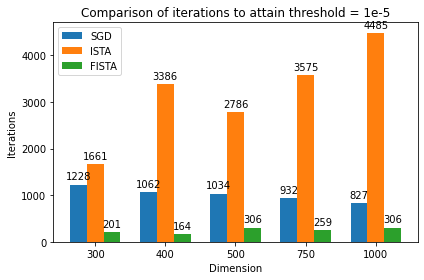

In [19]:
# SGD without nesterov acceleration - tolerance level = 0.00001
# n = 300 (1228, 1661, 201)
# n = 400 (1062, 3386, 164)
# n = 500 (1034, 2786, 306)
# n = 750 (932, 3575, 259)
# n = 1000 (827, 4485, 306)

# Wih tolerance level = 1e ^(-8)
# n = 500 (1283, 6124, 458)
# n = 1000 (1154, 7675, 640)
# n = 2000 (1084, 11869, 1026)

epochs_vals = [1228, 1062, 1034, 932, 827]
ista_vals = [1661, 3386, 2786, 3575, 4485]
fista_vals = [201, 164, 306, 259, 306]
n = [300, 400, 500, 750, 1000]
x = np.arange(len(n))
width = 0.24
fig, ax = plt.subplots()
SGD = ax.bar(x - width, epochs_vals, width, label = 'SGD')
ISTA = ax.bar(x, ista_vals, width, label = 'ISTA')
FISTA = ax.bar(x + width, fista_vals, width, label = 'FISTA')
ax.set_ylabel('Iterations')
ax.set_title('Comparison of iterations to attain threshold = 1e-5')
ax.set_xticks(x)
ax.set_xticklabels(n)
ax.set_xlabel('Dimension')
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
ax.legend()
autolabel(SGD)
autolabel(ISTA)
autolabel(FISTA)
fig.tight_layout()
# plt.savefig('No of iteraions.png')
plt.show()